# Web scraping from PubMed, to get the statistics of keywords with all the publications associated with "cardiovascular" within in year

Read API keys for NCBI (free account required)

In [62]:
# get api key from your .env file
import os
#!pip install python-dotenv

from dotenv import load_dotenv

load_dotenv()
API_KEY = os.getenv('NCBI_API')

#print(API_KEY)

In [63]:
#import packages
import requests
import json
import re
from bs4 import BeautifulSoup
from lxml import html

import numpy as np
import pandas as pd

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from fuzzywuzzy import fuzz


In [64]:
'''
API query:
Search in pubmed database that all the publications have cardiovascular in the title and published in 2020 or 2021
limit 100 records
'''


pubmed_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?\
db=pubmed&term=cardiovascular[title]+AND+(2020+OR+2021)&retmax=100&api_key={API_KEY}"


print(pubmed_url)

r = requests.get(pubmed_url)


'''
Check the format of the html text
'''
r.text

https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=cardiovascular[title]+AND+(2020+OR+2021)&retmax=100&api_key=61817d0fe1f57b4536319d42a03f393fb308


'<?xml version="1.0" encoding="UTF-8" ?>\n<!DOCTYPE eSearchResult PUBLIC "-//NLM//DTD esearch 20060628//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20060628/esearch.dtd">\n<eSearchResult><Count>17632</Count><RetMax>100</RetMax><RetStart>0</RetStart><IdList>\n<Id>34649254</Id>\n<Id>34649119</Id>\n<Id>34648905</Id>\n<Id>34648890</Id>\n<Id>34648724</Id>\n<Id>34648415</Id>\n<Id>34648111</Id>\n<Id>34648097</Id>\n<Id>34648072</Id>\n<Id>34648023</Id>\n<Id>34647590</Id>\n<Id>34647588</Id>\n<Id>34647583</Id>\n<Id>34647580</Id>\n<Id>34647487</Id>\n<Id>34647180</Id>\n<Id>34647161</Id>\n<Id>34647109</Id>\n<Id>34647025</Id>\n<Id>34646875</Id>\n<Id>34646873</Id>\n<Id>34646871</Id>\n<Id>34646868</Id>\n<Id>34646376</Id>\n<Id>34646137</Id>\n<Id>34646135</Id>\n<Id>34646111</Id>\n<Id>34645924</Id>\n<Id>34645650</Id>\n<Id>34645615</Id>\n<Id>34645614</Id>\n<Id>34645536</Id>\n<Id>34645467</Id>\n<Id>34645430</Id>\n<Id>34645342</Id>\n<Id>34645286</Id>\n<Id>34645280</Id>\n<Id>34644796</Id>\n<Id>34644731</I

In [65]:
'''
get the total number of records in counts tag feed back to url to get the completed searched results
And from the completed search result, extract all IDs from r.text
All IDs are under 'esearchresult.idList'

'''


soup = BeautifulSoup(r.text, 'html.parser')

total_records = re.findall(r'\d+', str(soup.count))[0]

new_pubmed_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?\
db=pubmed&term=cardiovascular[title]+AND+(2020+OR+2021)&retmax={total_records}&api_key={API_KEY}"


new_r = requests.get(new_pubmed_url)


full_soup = BeautifulSoup(new_r.text, 'html.parser')


list_of_ids = []

for id_line in tqdm(full_soup.esearchresult.idlist):
    id_res = re.findall(r'\d+', str(id_line))
    if len(id_res) > 0:
        list_of_ids.append(id_res[0])
        

print(f"We have total {len(list_of_ids)} records, and the first 10 records ids are:\n")        
print(list_of_ids[:10])

  0%|          | 0/35265 [00:00<?, ?it/s]

We have total 17632 records, and the first 10 records ids are:

['34649254', '34649119', '34648905', '34648890', '34648724', '34648415', '34648111', '34648097', '34648072', '34648023']


### Extract keywords from each matched literature on pubmed 

In [66]:
#Check on a random record first
import xmltojson
new_url="https://pubmed.ncbi.nlm.nih.gov/34458211"

r = requests.get(new_url)

soup = BeautifulSoup(r.text, 'html.parser')

print(soup.prettify()[:1000])
print(f"The full length of the string is {len(soup.prettify())}")

<!DOCTYPE html>
<html lang="en">
 <head itemscope="" itemtype="http://schema.org/WebPage" prefix="og: http://ogp.me/ns#">
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <!-- Mobile properties -->
  <meta content="True" name="HandheldFriendly"/>
  <meta content="320" name="MobileOptimized"/>
  <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
  <link href="https://cdn.ncbi.nlm.nih.gov" rel="preconnect"/>
  <link href="https://www.ncbi.nlm.nih.gov" rel="preconnect"/>
  <link href="https://www.google-analytics.com" rel="preconnect"/>
  <link href="https://cdn.ncbi.nlm.nih.gov/pubmed/d3976cdb-f249-4f7f-a740-d36a9f43aa7f/CACHE/css/output.35e8b192ea09.css" rel="stylesheet" type="text/css"/>
  <link href="https://cdn.ncbi.nlm.nih.gov/pubmed/d3976cdb-f249-4f7f-a740-d36a9f43aa7f/CACHE/css/output.452c70ce66f7.css" rel="stylesheet" type="text/css"/>
  <link href="https://cdn.ncbi.nlm.nih.gov/pubmed/d3976cdb-f249-4f7f-a740-d36a9f43aa7f/CA

In [67]:
#Check structures of a keyword session, 
#The keyword are included in "abstract" division, under one of the <p> Tags
page = requests.get(new_url)
tree = html.fromstring(page.content)
keywords = tree.xpath('//div[@class="abstract"]//p//text()')
for k in range(len(keywords)):
    print(f"{k}: {keywords[k]}")

0: 
      
      Cardiovascular disease (CVD) is an evolving process that begins in the early stages of chronic kidney disease (CKD) in children. Several surrogate markers, such as ambulatory blood pressure monitoring (ABPM), left ventricular (LV) mass, and arterial stiffness assessment, allow for the early detection of subclinical CVD in pediatric CKD. Four groups of plasma samples (
1: n
2:  = 3/group) from congenital anomalies of the kidney and urinary tract (CAKUT), as well as non-CAKUT patients with or without BP abnormalities, were studied to screen differentially expressed proteins using isobaric tags for relative and absolute protein quantification (iTRAQ)-based proteomics. As a result, 20 differentially expressed proteins associated with hypertension in children with CKD were discovered. Among them, apolipoprotein C-II (apoC-II) was found to have the highest abundance among the CKD patients with hypertension. As such, we hypothesized that apoC-II and apolipoprotein C-III (apoC

In [68]:
'''
get all possible keywords from all publication ids
Case 1: list of keywords are in the line next to the "Keywords:" line
Case 2: list of keywords are in the same line with the "Keywords"
Case 3: Do not have keywords: ignore
'''



list_of_keywords = []

url_prefix = "https://pubmed.ncbi.nlm.nih.gov/"

count = 0

for i in tqdm(range(len(list_of_ids))):
    
    id = list_of_ids[i]
    
    
    page = requests.get(f"{url_prefix}{id}")
    tree = html.fromstring(page.content)
    
    abstracts = tree.xpath('//div[@class="abstract"]//p//text()')
    
    
      
    
    
    for j in range(len(abstracts)):
        line = abstracts[j]
        if "Keywords" in line: #case3 ignore
            count += 1
            try:
                #case 1
                list_of_keywords += [x.lstrip().replace(".","") for x in abstracts[j+1].lstrip().split(";")]
                
            except:#Case2
                list_of_keywords += [x.lstrip().replace(".","") for x in re.split('; |, ',line.lstrip()) if x!="Keywords"]
                
            break
            
            
    
    
    
print(f"Total number of keywords extracted is {len(list_of_keywords)}")
print(f"{round(count/len(list_of_ids)*100,2)}% articles have keywords")    
    
    
    
    
            
        
    
    
    


  0%|          | 0/17632 [00:00<?, ?it/s]

Total number of keywords extracted is 64801
69.22% articles have keywords


In [69]:
#strip the text part from the keywords and get the number of unique key words
list_of_keywords = [s.strip() for s in list_of_keywords]


processed_keywords = [x.lower() for x in list_of_keywords]

unique_key_words = set(processed_keywords)

#unique_key_words = set([s.strip() for s in list_of_keywords])

words_count_pd = pd.DataFrame(pd.DataFrame(processed_keywords).value_counts().sort_values(ascending=False))

words_count_pd.columns = ["counts"]


print(words_count_pd.head());

                         counts
0                              
cardiovascular disease     2786
cardiovascular diseases    1121
hypertension                623
heart failure               595
atherosclerosis             593


### Similar keywords need to be combined ###
<b> Clustering key words that are similar to each other in the sample group (fuzzy ratio >=90), summarize read counts for each group to obtain the combined word count matrix; <br>
Dissimilar words but with the same meanings, such as (COVID-19 vs coronavirus) or (cardiovascular disease vs CVD) were combined manually. <b>


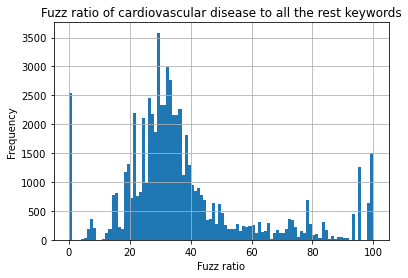

In [78]:
#check the fuzzy ratio distribution of cardiovascular disease

k1 = "cardiovascular disease"
list_of_fuzz_ratio = [fuzz.ratio(k1, x) for x in list_of_keywords]

pd.DataFrame(list_of_fuzz_ratio).hist(bins=100)
plt.title("Fuzz ratio of cardiovascular disease to all the rest keywords")
plt.ylabel("Frequency")
plt.xlabel("Fuzz ratio")
plt.show()


In [79]:
#Select 90 as the threshold based on Histogram
threshold = 90

word_dict = dict()

count_rows  = 0

tmp_unique = list(unique_key_words)

pbar = tqdm(total=len(tmp_unique))

#combine similar keywords and create a new keyword counts dataframe

while len(tmp_unique) > 0:
    
    #if len(tmp_unique)%round(len(unique_key_words)/10) == 0:
    #    print(f"Finished {round(10-len(tmp_unique)/round(len(unique_key_words)/10), 2)*10}%")
        
    
    
    #took the first one as new key words
    word = tmp_unique[0]
    
    if len(word) == 0:
        print(word)
        tmp_unique = tmp_unique[1:]
        pbar_update = 1
        #continue
    else:
        
        all_matched_words = [x for x in tmp_unique if fuzz.ratio(word, x)>=threshold]
        

        all_matched_pd = words_count_pd.loc[all_matched_words, "counts"]
        
        
        #assign best word as the one in all the matches with highest frequency
        best_word = all_matched_words[np.argmax(all_matched_pd)]
        
        
        best_word = all_matched_words[np.argmax(all_matched_pd)]

        best_score = 0
        
        #Check if there aresimilar words already exist in the word dictionary
        for key, value in word_dict.items():
            temp_score = fuzz.ratio(key, best_word)
            if temp_score >=threshold and temp_score > best_score:
                best_word = key
                best_score = temp_score

        if best_score == 0:
            word_dict[best_word] = all_matched_pd.sum()
        else:
            word_dict[best_word] += all_matched_pd.sum()
              

        
            
                
        #remove grouped words from tmp unique
        
        pbar_update = len(set(all_matched_words))
        
        
        tmp_unique = list(set(tmp_unique) - set(all_matched_words))
        
    #update progress bar

    pbar.update(pbar_update);
   
        

        
word_pd = pd.DataFrame.from_dict(word_dict, orient='index', columns = ["counts"])

print(word_pd.head())



  0%|          | 0/20422 [00:00<?, ?it/s]


                                     counts
endothelial progenitor cells (epcs)       1
tx, texas                                 1
gen enos                                  1
advanced age                              2
mitochondrial protein                     1


In [88]:
'''
#manually combined Covid-19, and coronavirus
#manually combined cvd, and cardiovascular disease to cardiovascular category 
'''


word_pd.loc['covid-19'] = word_pd.loc[['covid-19', 'coronavirus']].sum()

word_pd = word_pd.drop(['coronavirus'])



word_pd.loc['cardiovascular disease'] = word_pd.loc[['cardiovascular disease', 'cvd']].sum()

word_pd = word_pd.drop(['cvd'])



### Create word count for the results

In [89]:
#first of all, Took Top 100 most frequent words

word_pd = word_pd.sort_values('counts', ascending=False)

#there are some string has "\n" not removed

word_pd.index = [x.replace("\n", " ").replace("#", "") for x in word_pd.index]


word_Top100 = word_pd.iloc[:100]

print(word_Top100)

                              counts
cardiovascular disease          4092
hypertension                     624
atherosclerosis                  610
heart failure                    596
mortality                        571
...                              ...
cardiovascular complications      68
gender                            67
congenital heart disease          67
air pollution                     66
cardiac magnetic resonance        65

[100 rows x 1 columns]


In [90]:
#create text string list for word cloud

text_strs = []

for row in word_Top100.itertuples():
    text_strs += [row.Index]*row.counts

print(f"Total lenght of text strs is {len(text_strs)}, containing {len(set(text_strs))} unique words.")

Total lenght of text strs is 21699, containing 100 unique words.


### Create word cloud plot based on each of Top 100 words frequencies

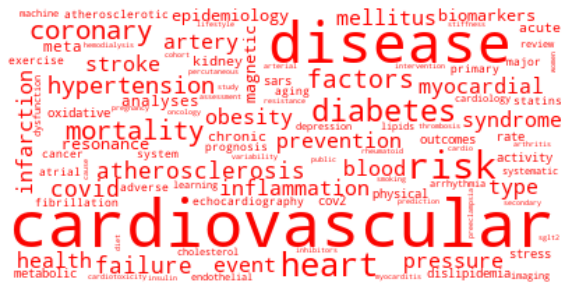

In [91]:


def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(001,100%%, %d%%)" % np.random.randint(49,51))


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", collocations=False).\
generate(', '.join(text_strs))
wordcloud.recolor(color_func = grey_color_func)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>As suggested by the word cloud, the latest research hotspots on cardiovascular diseases include diabetes, hypertension, atherosclerosis, stroke and heart failture, which can be correlated with the glucose, systolic and diastolic blood pressure and cholesterol levels in the <a href="https://www.kaggle.com/sulianova/cardiovascular-disease-dataset">kaggle cardiovascular disease dataset</a>. Atherosclerosis is the result of arteireis inflammation and half of the atherosclerosis may cause stroke. Smoking may exacerbate the symptom while COVID-19 virus may also contribute to heart injuries.</b> 